## basic classifier for Dna2Vec represenation

Basic bacterial genome classification using Dna2Vec representation

In [1]:
%load_ext autoreload
%autoreload 2

In [37]:
from faigen.genomic import sequence 

In [38]:
import sys
sys.path.append("..")
from faigen.data import sequence 
# from genomic import sequence
from faigen.data.sequence import regex_filter, count_filter, Dna2VecDataBunch
from functools import partial
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn import manifold,neighbors
from scipy.cluster.hierarchy import dendrogram, linkage  
from matplotlib import pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import plotly.plotly as py
import plotly.graph_objs as go
from fastai import *
from fastai.data_block import *
from fastai.basic_train import *
from fastai.layers import *
from fastai.metrics import *
import torch.nn as nn
import torch.nn.functional as F

### Load Data

In [2]:
from gensim.models import Word2Vec
# word_vectors = Word2Vec.load_word2vec_format('/data/genomes/embeddings/dna2vec-20190612-1611-k10to10-100d-10c-4870Mbp-sliding-kPR.w2v') 

word_vectors = Word2Vec.load_word2vec_format('/data/genomes/embeddings/dna2vec-20190611-1940-k8to8-100d-10c-4870Mbp-sliding-LmP.w2v') 



In [5]:
filters=[partial(regex_filter, rx="Streptomyces|Bacillus|Vibrio|Streptococcus|Rhizobium|Staphylococcus"),partial(regex_filter, rx="plasmid", keep=False)]
items = sequence.Dna2VecList.from_folder("/data/genomes/GenSeq_fastas/train",filters=filters,agg=partial(np.mean, axis=0),n_cpus=7,emb=word_vectors)
processors = [
    sequence.GSFileProcessor(),
    sequence.GSTokenizeProcessor(tokenizer=sequence.GSTokenizer(ngram=10, skip=0, n_cpus=7)),
    sequence.Dna2VecProcessor(emb=word_vectors)]
for p in processors:
    print("\n", type(p))
    %time p.process(items)


 <class 'genomic.sequence.GSFileProcessor'>
CPU times: user 792 ms, sys: 28 ms, total: 820 ms
Wall time: 820 ms

 <class 'genomic.sequence.GSTokenizeProcessor'>
CPU times: user 4.76 s, sys: 176 ms, total: 4.93 s
Wall time: 4.93 s

 <class 'genomic.sequence.Dna2VecProcessor'>
CPU times: user 3min 49s, sys: 166 ms, total: 3min 50s
Wall time: 3min 50s


In [67]:
bunch.sanity_check()

In [39]:
DB="/data/genomes/GenSeq_fastas"
# DB='/home/serge/development/genomes/ncbi-genomes-2019-04-07/bacterial genomes'

filters=[partial(regex_filter, rx="Bacillus",keep=False),partial(regex_filter, rx="plasmid?\s", keep=False)]    
#        partial(count_filter,num_fastas=(1,1), keep=1)]

bunch = Dna2VecDataBunch.from_folder(DB,
             filters=filters,
             labeler=lambda x: x.split()[1],
             emb=word_vectors,ngram=8,skip=0,
             n_cpus=7,agg=partial(np.mean, axis=0), one_hot=True,bs=5)


../faigen/data/sequence.py:362: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



In [6]:
bunch.one_batch()

(tensor([[ 0.0645, -0.2872, -0.0565, -0.0035,  0.2611, -0.0581, -0.0974,  0.0791,
          -0.0033,  0.0354, -0.1201,  0.0797,  0.4888, -0.2327,  0.0385,  0.0012,
           0.0010, -0.0173, -0.0215, -0.1770,  0.2252,  0.2270,  0.0441,  0.1425,
           0.0319, -0.1449, -0.0564,  0.1623, -0.0063,  0.2955,  0.0319, -0.0049,
           0.1545,  0.0335, -0.1812, -0.0363, -0.1245,  0.0646, -0.0411, -0.0247,
          -0.1640,  0.2380, -0.0977, -0.0708, -0.0517, -0.0311,  0.2524,  0.0503,
          -0.0663, -0.1152,  0.1973,  0.0954, -0.1255, -0.0057,  0.0548,  0.0498,
           0.1748,  0.1425,  0.0037,  0.0763,  0.1242,  0.0503,  0.2337, -0.2296,
          -0.2063, -0.3261, -0.0014, -0.2051, -0.0520, -0.0805,  0.0730, -0.1465,
           0.0566,  0.0843,  0.2293,  0.0049,  0.3408, -0.0223,  0.1707,  0.0475,
           0.1269, -0.4170, -0.1300, -0.0997, -0.0961, -0.1751,  0.1074, -0.0183,
          -0.2679,  0.0532,  0.0268, -0.0753,  0.0468, -0.2390,  0.0514, -0.0319,
          -0.217

In [7]:

class GenomeClassifier(nn.Module):
    def __init__(self):
        super(GenomeClassifier, self).__init__()
        self.l1 = nn.Linear(100, 100)
        self.linear_classifier = nn.Linear(100, bunch.train_dl.y.c)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.linear_classifier(x)
        return x

In [12]:
class BactClassifier(SequentialEx):
    pass

In [19]:
layers=[nn.Linear(100,100),nn.ReLU(),nn.Linear(100,17)]

In [20]:
bc = SequentialEx(*layers)

In [21]:
bc

SequentialEx(
  (layers): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=17, bias=True)
  )
)

In [25]:
learn = Learner(bunch, bc)

In [26]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


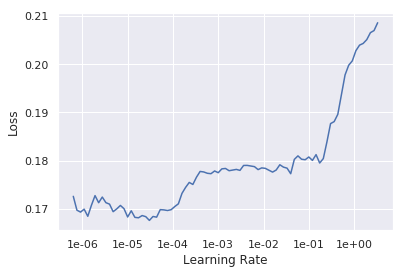

In [27]:
learn.recorder.plot()

In [28]:
learn.fit(1)

IndexError: Traceback (most recent call last):
  File "/home/serge/anaconda3/envs/bio-2/lib/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 99, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/serge/anaconda3/envs/bio-2/lib/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 99, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/serge/anaconda3/envs/bio-2/lib/python3.6/site-packages/fastai/data_block.py", line 636, in __getitem__
    if self.item is None: x,y = self.x[idxs],self.y[idxs]
  File "/home/serge/anaconda3/envs/bio-2/lib/python3.6/site-packages/fastai/data_block.py", line 109, in __getitem__
    if isinstance(idxs, Integral): return self.get(idxs)
  File "/home/serge/anaconda3/envs/bio-2/lib/python3.6/site-packages/fastai/data_block.py", line 410, in get
    o = self.items[i]
IndexError: index 17 is out of bounds for axis 0 with size 17


In [ ]:
%debug

> /home/serge/anaconda3/envs/bio-2/lib/python3.6/site-packages/torch/utils/data/dataloader.py(608)_process_next_batch()
    606                 raise Exception("KeyError:" + batch.exc_msg)
    607             else:
--> 608                 raise batch.exc_type(batch.exc_msg)
    609         return batch
    610 

ipdb> batch


In [62]:
learn.fit_one_cycle(25)

In [9]:
processors = [
    sequence.GSFileProcessor(),
    sequence.GSTokenizeProcessor(tokenizer=sequence.GSTokenizer(ngram=8, skip=0, n_cpus=4)),
    sequence.Dna2VecProcessor()]
%time for p in processors: p.process(data)

CPU times: user 42min 11s, sys: 8min 41s, total: 50min 52s
Wall time: 1h 25min 43s


In [10]:
len(data.items)

1686

###  Genome vectors

In [11]:
data.items

[array([-10600.021 ,  95022.27  ,  -4546.29  , -28514.387 , ..., -29253.547 , -42794.895 , -26871.03  ,  -7630.3984],
       dtype=float32),
 array([ -9848.35  , 132596.69  ,  -7269.2188, -46002.242 , ..., -16791.951 , -45528.703 , -51696.32  , -16984.848 ],
       dtype=float32),
 array([-11893.81 , 148440.22 ,  -8725.728, -52156.43 , ..., -19914.074, -50862.883, -56499.875, -17946.658],
       dtype=float32),
 array([-18210.059, 117143.05 , -11808.324, -37285.65 , ..., -43233.8  , -61256.727, -33373.516,  -5143.087],
       dtype=float32),
 array([-17936.713, 114599.05 , -10966.08 , -35446.773, ..., -41979.465, -59523.035, -32904.266,  -5278.633],
       dtype=float32),
 array([-17462.723 , 114580.625 , -11426.668 , -36419.715 , ..., -42048.332 , -59268.53  , -32817.168 ,  -5567.8833],
       dtype=float32),
 array([-18008.34 , 114250.88 , -11187.709, -35736.53 , ..., -41940.695, -59488.145, -32739.904,  -5188.623],
       dtype=float32),
 array([ -4641.001 , 117018.06  ,   5746.5435

In [14]:
def log_scale(X):
    x=np.asarray(X);e=1e-6
    return np.log10(x+np.abs(x.min())+e) 


x=np.asarray(data.items)
bad_fastas = np.where(np.mean(x,axis=1) == 0.)[0]
X = np.delete(x, bad_fastas,0)
labelList=[" ".join(i.split()[1:3]) for i in data.descriptions]
labelList=np.delete(np.asarray(labelList), bad_fastas)
vocab=list(np.unique(labelList))
y=[vocab.index(x) for x in labelList]

## Correlation Distance in log-scaled space

### tSNE

In [18]:
tsne = manifold.TSNE(n_components=3, init='pca', perplexity=10, metric="correlation",random_state=0)
%time X3 = tsne.fit_transform(log_scale(X))

CPU times: user 31.1 s, sys: 313 ms, total: 31.4 s
Wall time: 30.9 s


In [19]:
genus = [i.split()[0] for i in labelList]
genus_vocab=list(np.unique(genus))
y=[genus_vocab.index(x) for x in genus]
genus_vocab

X3_df = pd.DataFrame(data=X3, columns=["pc1",'pc2','pc3'], index=labelList)

X3_df["genus"]=genus
X3_df["y"]=y

genus_df=X3_df.groupby("genus").agg({"pc1": list, "pc2":list,"pc3":list,"y":np.mean})

### Correlation Distance visualisation

In [20]:
data=[]
for g in genus_df.index:
    trace  = go.Scatter3d(
        name = str(g),
        x=genus_df.loc[g,"pc1"],
        y=genus_df.loc[g,"pc2"],
        z=genus_df.loc[g,"pc3"],
        mode='markers',
        marker=dict(
            size=8,
            color=genus_df.loc[g,"y"],                # set color to an array/list of desired values
            colorscale='Jet',           # choose a colorscale
            opacity=0.5)
    )

    data.append(trace)
    

layout = go.Layout(
    width=1000,
    height=1000,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='correlation distance ncbi-genomes-2019-04-07 Escherichia,Klebsiella,Bacillus')

/home/serge/anaconda3/envs/bio/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



## Eucleadian Distance in log-scaled space

### tSNE

In [21]:
tsne = manifold.TSNE(n_components=3, init='pca', perplexity=30,random_state=0)
%time X3 = tsne.fit_transform(log_scale(X))

CPU times: user 25.8 s, sys: 334 ms, total: 26.1 s
Wall time: 25.5 s


In [22]:
genus = [i.split()[0] for i in labelList]
genus_vocab=list(np.unique(genus))
y=[genus_vocab.index(x) for x in genus]
genus_vocab

X3_df = pd.DataFrame(data=X3, columns=["pc1",'pc2','pc3'], index=labelList)

X3_df["genus"]=genus
X3_df["y"]=y

genus_df=X3_df.groupby("genus").agg({"pc1": list, "pc2":list,"pc3":list,"y":np.mean})

### Eucleadian Distance Visualisation

In [32]:
data=[]
for g in genus_df.index:
    trace  = go.Scatter3d(
        name = str(g),
        x=genus_df.loc[g,"pc1"],
        y=genus_df.loc[g,"pc2"],
        z=genus_df.loc[g,"pc3"],
        mode='markers',
        marker=dict(
            size=8,
            color=genus_df.loc[g,"y"]+1,                # set color to an array/list of desired values
            colorscale='YlGnBu',           # choose a colorscale
            opacity=0.5)
    )

    data.append(trace)
    

layout = go.Layout(
    width=1000,
    height=1000,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='eucledian distance metric by genus Escherichia|Klebsiella|Bacillus')

/home/serge/anaconda3/envs/bio/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



## Eucleadian Distance in unmodified space

### tSNE

In [27]:
tsne = manifold.TSNE(n_components=3, init='pca', perplexity=30,random_state=0)
%time X3 = tsne.fit_transform(X)

CPU times: user 41.5 s, sys: 313 ms, total: 41.8 s
Wall time: 41.2 s


In [28]:
genus = [i.split()[0] for i in labelList]
genus_vocab=list(np.unique(genus))
y=[genus_vocab.index(x) for x in genus]
genus_vocab

X3_df = pd.DataFrame(data=X3, columns=["pc1",'pc2','pc3'], index=labelList)

X3_df["genus"]=genus
X3_df["y"]=y

genus_df=X3_df.groupby("genus").agg({"pc1": list, "pc2":list,"pc3":list,"y":np.mean})

### Eucleadian Distance Visualisation

In [29]:
data=[]
for g in genus_df.index:
    trace  = go.Scatter3d(
        name = str(g),
        x=genus_df.loc[g,"pc1"],
        y=genus_df.loc[g,"pc2"],
        z=genus_df.loc[g,"pc3"],
        mode='markers',
        marker=dict(
            size=8,
            color=genus_df.loc[g,"y"],                # set color to an array/list of desired values
            colorscale='Jet',           # choose a colorscale
            opacity=0.5)
    )

    data.append(trace)
    

layout = go.Layout(
    width=1000,
    height=1000,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='eucledian distance in native space Escherichia|Klebsiella|Bacillus')

/home/serge/anaconda3/envs/bio/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



## Genome Inventory

In [8]:
all_fastas = sequence.Dna2VecList.from_folder(DB)

In [28]:
next(iter(all_fastas))

{'file': '/home/serge/development/genomes/ncbi-genomes-2019-04-07/bacterial genomes/GCF_003261035.1_ASM326103v1_genomic.fna',
 'description': 'NZ_CP030062.1 Mannheimia varigena strain Teagasc 1 chromosome, complete genome',
 'id': 'NZ_CP030062.1',
 'name': 'NZ_CP030062.1'}

In [30]:
a = [x for x in all_fastas if "plasmid" not in x['description'].split()] 

In [31]:
a

[{'file': '/home/serge/development/genomes/ncbi-genomes-2019-04-07/bacterial genomes/GCF_003261035.1_ASM326103v1_genomic.fna',
  'description': 'NZ_CP030062.1 Mannheimia varigena strain Teagasc 1 chromosome, complete genome',
  'id': 'NZ_CP030062.1',
  'name': 'NZ_CP030062.1'},
 {'file': '/home/serge/development/genomes/ncbi-genomes-2019-04-07/bacterial genomes/GCF_000750395.2_ASM75039v2_genomic.fna',
  'description': 'NZ_CP009085.2 Salmonella enterica subsp. enterica serovar Enteritidis strain OLF-SE3-98983-4, complete genome',
  'id': 'NZ_CP009085.2',
  'name': 'NZ_CP009085.2'},
 {'file': '/home/serge/development/genomes/ncbi-genomes-2019-04-07/bacterial genomes/GCF_900205745.1_Lf_IMDO_130101_genomic.fna',
  'description': 'NZ_LT906621.1 Lactobacillus fermentum strain IMDO 130101 genome assembly, chromosome: I',
  'id': 'NZ_LT906621.1',
  'name': 'NZ_LT906621.1'},
 {'file': '/home/serge/development/genomes/ncbi-genomes-2019-04-07/bacterial genomes/GCF_001854145.2_ASM185414v2_genomic.

In [25]:
a = pd.DataFrame(data=list(a.items), columns=["file", "description","id","name"]).groupby("file").agg({"id":'count'}).sort_values('id', ascending=False)

AttributeError: 'list' object has no attribute 'items'

In [20]:
a.describe()

id
count  13050.000000
mean       1.956552
std        1.742139
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       22.000000

In [26]:
inventory = pd.DataFrame(data=[l.split()[1:3] for l in all_fastas], columns=["genus","species" ])

In [30]:
inventory.groupby("genus").agg({"species":"count"}).sort_values("species",ascending=False)

species
genus                   
Escherichia         2239
Klebsiella          1718
Salmonella          1183
Bacillus            1172
Lactobacillus        953
Staphylococcus       889
Burkholderia         650
Enterococcus         626
Pseudomonas          613
Streptococcus        564
Acinetobacter        531
Bordetella           504
Vibrio               474
Xanthomonas          395
Mycobacterium        368
Borrelia             347
Campylobacter        339
Rhizobium            307
Enterobacter         298
Mycoplasma           290
Corynebacterium      258
Phaeobacter          256
Yersinia             243
Brucella             233
Clostridium          228
Listeria             227
Streptomyces         225
Chlamydia            202
Helicobacter         187
Candidatus           187
...                  ...
'Deinococcus           1
Mariniflexile          1
Marinithermus          1
Lactobacillales        1
Marinobacterium        1
Megamonas              1
Melioribacter          1
Melittangium           1
Methylobacillus        1
Methylocaldum          1
Magnetococcus          1
Mageeibacillus         1
Lysinimonas            1
Luteitalea             1
Lacunisphaera          1
Lautropia              1
Leadbetterella         1
Leminorella            1
Lentibacillus          1
Lentzea                1
Leptothrix             1
Levyella               1
Limnobaculum           1
Limnochorda            1
Litorilituus           1
Lonsdalea              1
Luteibacter            1
Luteipulveratus        1
secondary              1
plasmid1               0

[1120 rows x 1 columns]

In [6]:
all_fasts

NameError: name 'all_fasts' is not defined

In [24]:
inventory.groupby(["genus", "species"]).agg({"species": "count"})
inventory.columns=["count"]
inventory

count
genus            species                
'Catharanthus    roseus'               2
'Deinococcus     soli'                 1
'Nostoc          azollae'              3
18,711,729       reads                 1
Acaryochloris    marina               10
Acetobacter      aceti                 1
                 ascendens             1
                 orientalis            2
                 oryzifermentans       1
                 pasteurianus         91
                 persici               2
                 pomorum               7
                 senegalensis          2
                 sp.                   7
                 tropicalis            2
Acetobacterium   woodii                1
Acetohalobium    arabaticum            1
Acetomicrobium   mobile                1
Acholeplasma     axanthum              1
                 hippikon              2
                 laidlawii             2
                 oculi                 1
Achromobacter    denitrificans         3
                 insolitus             4
                 sp.                   2
                 spanius               4
                 xylosoxidans         11
Acidaminococcus  fermentans            1
                 intestini             1
Acidiferrobacter sp.                   1
...                                  ...
Zymobacter       palmae                2
Zymomonas        mobilis              49
[Arcobacter]     porcinus              1
[Bacillus        thuringiensis]        2
[Bacillus]       caldolyticus          2
                 selenitireducens      1
[Brevibacterium] flavum                2
                 frigoritolerans       1
[Clostridium]    bolteae               2
                 cellulolyticum        1
                 cellulosi             1
                 clariflavum           1
                 propionicum           1
                 saccharolyticum       1
                 scindens              1
                 stercorarium          4
[Enterobacter]   lignolyticus          1
[Eubacterium]    eligens               3
                 hallii                1
                 rectale               1
[Haemophilus]    ducreyi              14
                 parasuis              4
[Mycobacterium]  chelonae              2
[Pasteurella]    aerogenes             1
[Polyangium]     brachysporum          1
[Pseudomonas     syringae]             3
[Pseudomonas]    mesoacidophila        4
complete         chromosome            2
gamma            proteobacterium       1
secondary        endosymbiont          1

[3186 rows x 1 columns]

In [25]:
all_fastas

['NZ_CP013305.1 Vibrio cholerae strain CRC1106 chromosome 1, complete sequence',
 'NZ_CP013306.1 Vibrio cholerae strain CRC1106 chromosome 2, complete sequence',
 'NC_013791.2 Bacillus pseudofirmus OF4, complete genome',
 'NC_013792.1 Bacillus pseudofirmus OF4 plasmid pBpOF4-01, complete sequence',
 'NC_013793.1 Bacillus pseudofirmus OF4 plasmid pBpOF4-02, complete sequence',
 'NC_000913.3 Escherichia coli str. K-12 substr. MG1655, complete genome',
 'NC_007164.1 Corynebacterium jeikeium K411 complete genome',
 'NC_003080.1 Corynebacterium jeikeium K411 plasmid pKW4, complete sequence',
 'NC_002162.1 Ureaplasma parvum serovar 3 str. ATCC 700970, complete genome',
 'NC_004088.1 Yersinia pestis KIM10+, complete genome',
 'NC_004838.1 Yersinia pestis KIM10+ plasmid pMT-1, complete sequence',
 'NC_002620.2 Chlamydia muridarum Nigg, complete genome',
 'NC_002182.1 Chlamydia muridarum Nigg plasmid pMoPn, complete sequence',
 'NC_002488.3 Xylella fastidiosa 9a5c, complete genome',
 'NC_002489

In [117]:
counts = inventory.reset_index().groupby("genus").agg({"count", sum}).drop(("species"), axis=1)
counts.columns=["n_sequences","species"]
counts.sort_values("n_sequences", ascending=False)

n_sequences  species
genus                                 
Bacillus                 1132       11
Streptomyces              743        5
Vibrio                    468        5
Rhizobium                 325        6
Pseudomonas               304        8
Staphylococcus            301        6
Clostridium               259        5
Streptococcus             222        6
Planktothrix              179        5
Stenotrophomonas          176        5
Escherichia               133        3
Paenibacillus             127        3
Listeria                  104        4
Corynebacterium           103        7
Klebsiella                 16        3
Shigella                   14        3
Salmonella                  4        2
Enterobacter                1        1